In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# CSV 파일 경로 설정
pollutants_path = '../../NewData/Weekly_Air_Pollutants.csv'
weather_path = '../data_preprocessing/normalized_analyze_abnormal.csv'

# 데이터 로드
pollutants_data = pd.read_csv(pollutants_path)
weather_data = pd.read_csv(weather_path)

In [3]:
# Positional Encoding 정의
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
    
# WeatherTransformer 정의 수정
class WeatherTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_layers, sequence_length, dropout=0.1):
        super(WeatherTransformer, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len=sequence_length)
        self.transformer = nn.Transformer(
            d_model=d_model, nhead=nhead, num_encoder_layers=num_layers, dropout=dropout
        )
        self.fc = nn.Linear(d_model, output_dim)
    
    def forward(self, x):
        # print(f"Model - Input shape: {x.shape}")  # 디버깅
        x = self.input_embedding(x)
        # print(f"Model - After input_embedding: {x.shape}")  # 디버깅
        x = self.positional_encoding(x)
        x = x.permute(1, 0, 2)
        # print(f"Model - After permute: {x.shape}")  # 디버깅
        x = self.transformer(x, x)
        x = x.permute(1, 0, 2)
        # print(f"Model - After Transformer: {x.shape}")  # 디버깅
        x = self.fc(x.mean(dim=1))
        # print(f"Model - After fc: {x.shape}")  # 디버깅
        return x


In [4]:
# 데이터 병합
pollutants_data['datetime'] = pd.to_datetime(pollutants_data['datetime'])
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
merged_data = pd.merge(weather_data, pollutants_data, on='datetime', how='inner')

# 시간 정보 추가
merged_data['day_of_year'] = merged_data['datetime'].dt.dayofyear
merged_data['week_of_year'] = merged_data['datetime'].dt.isocalendar().week
merged_data['year'] = merged_data['datetime'].dt.year

# 입력(X)와 출력(Y) 설정
input_features = ['CO', 'Nox', 'Sox', 'TSP', 'PM-10', 'VOCs', 'NH3', 'day_of_year', 'week_of_year', 'year']
target_features = ['temp', 'humidity', 'precip', 'windspeed']

X = merged_data[input_features].values
Y = merged_data[target_features].values

In [5]:
# 슬라이딩 윈도우로 시계열 데이터 생성
sequence_length = 7
def create_sequences(data, target, sequence_length):
    X_seq, Y_seq = [], []
    for i in range(len(data) - sequence_length):
        X_seq.append(data[i:i+sequence_length])  # 슬라이딩 윈도우
        if target is not None:
            Y_seq.append(target[i+sequence_length])  # 다음 시점의 모든 출력값
    return np.array(X_seq), np.array(Y_seq)  # 3D (samples, sequence_length, features), 2D (samples, output_dim)



# 데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# MinMaxScaler 적용 (2D 형태로 처리)
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
Y_train_scaled = scaler_Y.fit_transform(Y_train)  # (samples, output_dim)
Y_test_scaled = scaler_Y.transform(Y_test)

# 슬라이딩 윈도우로 시계열 데이터 생성
X_train_seq, Y_train_seq = create_sequences(X_train_scaled, Y_train_scaled, sequence_length)
X_test_seq, Y_test_seq = create_sequences(X_test_scaled, Y_test_scaled, sequence_length)

# Tensor 변환
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_seq, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_seq, dtype=torch.float32)

# DataLoader 생성
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)

# 모델 출력 확인
print(f"Model output size: {len(target_features)}")  # 4



Model output size: 4


In [6]:
# 모델 하이퍼파라미터 설정
input_dim = len(input_features)
output_dim = len(target_features)
d_model = 1024
nhead = 32
num_layers = 16
dropout = 0.1
learning_rate = 0.0002
epochs = 100

# Early Stopping 설정
early_stopping_patience = 5
best_train_loss = float('inf')
best_test_loss = float('inf')
best_loss = float('inf')
patience_counter = 0

# 모델 초기화
input_dim = X_train_seq.shape[-1]  # 입력 데이터의 특징 차원
model = WeatherTransformer(
    input_dim=input_dim,
    output_dim=len(target_features),
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    sequence_length=sequence_length,
    dropout=dropout
)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

In [7]:
# 모델 학습
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # 검증
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            test_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_test_loss = test_loss / len(test_loader)
    scheduler.step(avg_test_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    # Early Stopping 체크
    if avg_train_loss < best_train_loss or avg_test_loss < best_test_loss:
        best_train_loss, best_test_loss = avg_train_loss, avg_test_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs.")
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

Epoch 1/100, Train Loss: 1.0692, Test Loss: 0.0429
Epoch 2/100, Train Loss: 0.0403, Test Loss: 0.0342
Epoch 3/100, Train Loss: 0.0416, Test Loss: 0.0528
No improvement for 1 epochs.
Epoch 4/100, Train Loss: 0.0398, Test Loss: 0.0355
Epoch 5/100, Train Loss: 0.0417, Test Loss: 0.0441
No improvement for 1 epochs.
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6/100, Train Loss: 0.0389, Test Loss: 0.0496
Epoch 7/100, Train Loss: 0.0380, Test Loss: 0.0462
Epoch 8/100, Train Loss: 0.0393, Test Loss: 0.0387
Epoch 9/100, Train Loss: 0.0400, Test Loss: 0.0334
Epoch 10/100, Train Loss: 0.0383, Test Loss: 0.0385
Epoch 11/100, Train Loss: 0.0368, Test Loss: 0.0454
Epoch 12/100, Train Loss: 0.0398, Test Loss: 0.0410
Epoch    13: reducing learning rate of group 0 to 5.0000e-05.
Epoch 13/100, Train Loss: 0.0376, Test Loss: 0.0350
Epoch 14/100, Train Loss: 0.0374, Test Loss: 0.0346
Epoch 15/100, Train Loss: 0.0360, Test Loss: 0.0363
Epoch 16/100, Train Loss: 0.0368, Test Loss: 0.

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

model.load_state_dict(torch.load("best_model.pth"))
model.eval()  # 모델을 평가 모드로 전환

# 전체 데이터 슬라이딩 윈도우로 시계열 생성
X_seq, Y_seq = create_sequences(X, Y, sequence_length)

# 데이터 스케일링
X_seq_scaled = scaler_X.transform(X_seq.reshape(-1, X_seq.shape[-1])).reshape(X_seq.shape)
Y_seq_scaled = scaler_Y.transform(Y_seq)

# Tensor 변환
X_tensor = torch.tensor(X_seq_scaled, dtype=torch.float32)

# 예측 수행
with torch.no_grad():
    predictions_scaled = model(X_tensor).numpy()  # 모델의 출력은 스케일링된 값

# 스케일 역변환
predictions = scaler_Y.inverse_transform(predictions_scaled)
actual_values = scaler_Y.inverse_transform(Y_seq_scaled)

# 평가
rmse = mean_squared_error(actual_values, predictions, squared=False)
mae = mean_absolute_error(actual_values, predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 7.8519
MAE: 6.6334


c:\Users\limul\.conda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


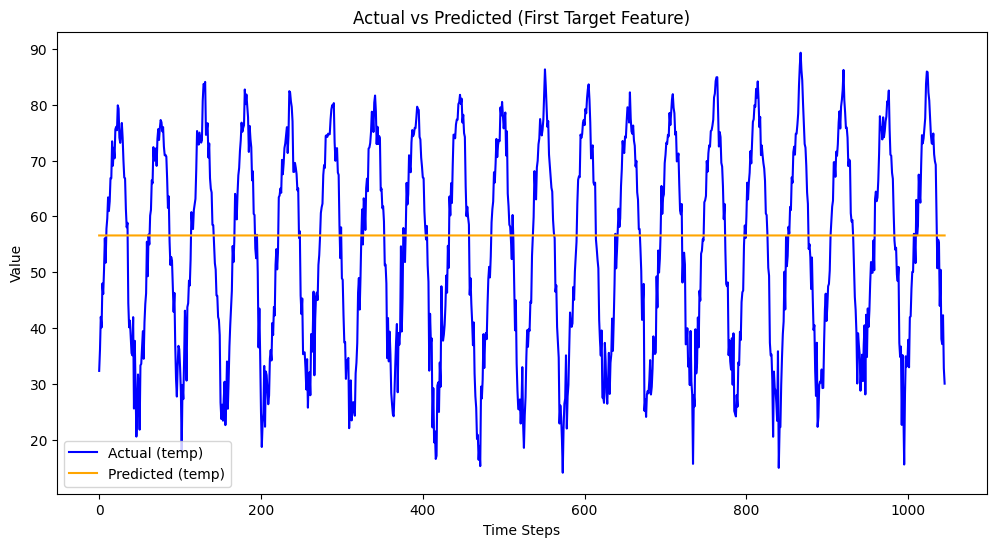

In [9]:
# 시각화 (예: 첫 번째 출력 변수)
plt.figure(figsize=(12, 6))
plt.plot(actual_values[:, 0], label="Actual (temp)", color="blue")
plt.plot(predictions[:, 0], label="Predicted (temp)", color="orange")
plt.legend()
plt.title("Actual vs Predicted (First Target Feature)")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.show()